In this code, I use image processing techniques to remove hair from skin images which would improve deep learning model performance. I mainly used OpenCV and the following shows the steps I took:

1- Import libraries <br>
2- Create the hair removal function: <br>

* Convert image to Grayscale <br>
* Apply Canny algorithm to detect edges <br>
* Exclude from edges those pixels that are very bright since they are probably not hair
* Morphologically close and erode the detected edges to remove smaller false positives and fill in false negatives <br>
* Identify coordinates of the edges using probabilistic Hough line transform <br>
* discard edges (lines) that are either too short or too long since they are likely false positives. <br>
* create a mask using the lines coordinates <br>
* dilate the mask to cover more areas for robust interpolation <br>
* interpolate the pixels in the mask using median of the neighboring pixels <br>

3- visualize some data samples

(Please note that there are some hyper-parameters in the function that may need to change according to your own dataset. I found these work best for ISIC skin dataset.)

# Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.catch_warnings 

import torchvision

import cv2 as cv

data_path = 'dataset\input_images\ISIC_0024306.jpg'

# Hair removal function

In [3]:
def remove_hair(images, cfg=None):
    num_images = len(images)
    if cfg is None:
        class CFG():
            def __init__(self):
                self.edge_low_threshold = 100 # edge high threshold in Canny algorithm
                self.edge_high_threshold = 220 # edge high threshold in Canny algorithm

                self.dark_spot_threshold = 150 # pixels brighter than this are ignored

                self.linelength_threshold = 10 # lines shorter than this are ignored

                self.divergence_threshold = 0.25 # Should be farther away from image center than this threshold to be considered hair
                self.patchiness_threshold = 0.15 # Should be more widespread than this threshold to be considered hair

                self.interp_win = 20
        cfg = CFG()
        

    fig, ax = plt.subplots(num_images, 6, figsize=(12, 2 * num_images))
    plt.subplots_adjust(wspace=0.01, hspace=0.2)
    for this_ax in ax.ravel():
        this_ax.set_axis_off()
    
    img_filtered_all = []
    for image_ind, img_orig in enumerate(images):
        image_size = img_orig.shape[:2]

        # -------------------------------------------------------- Check if input is RGB
        plt.sca(ax[image_ind, 0])
        
        if img_orig.ndim == 3:
            RGB_input = 1
            img = img_orig.mean(-1)
        else:
            RGB_input = 0
            img = img_orig.copy()
        plt.imshow(img_orig, cmap='gray')
        plt.title('Original')
        
        skip_flag = 0
    
        # -------------------------------------------------------- The Edges
        plt.sca(ax[image_ind, 1])

        kernel = np.ones((3,3),np.uint8)
        img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel) 
        img_filt = np.where(img_filt > 15, img_filt, 0)
        
        kernel = np.ones((4,4),np.uint8)
        img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)
        
        plt.imshow(img_filt, cmap='gray')
        plt.title('BlachHat')
        
        # -------------------------------------------------------- Edges within dark spots of image
        plt.sca(ax[image_ind, 2])
        
        dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
        kernel = np.ones((4,4),np.uint8)
        dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)
        
        img_filt = img_filt * dark_spots

        plt.imshow(img_filt, cmap='gray')
        plt.title('Only darker pixels')
    
        # -------------------------------------------------------- The Lines detected from the Edges
        plt.sca(ax[image_ind, 3])
        ``
        lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)

        if lines is not None:
            lines = lines.reshape(-1, 4)
            N_lines = lines.shape[0]

            # exclude short lines
            lines_to_interp = []
            for ind in range(N_lines):
                line = lines[ind, :]
                x, y = fill_line(line[0::2], line[1::2], 1)
                line_length = np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)

                if (line_length < cfg.linelength_threshold):
                    plt.scatter(x, y, 30, alpha=0.1, c='green')
                else:
                    plt.scatter(x, y, 1, alpha=0.5, c='red')
                    lines_to_interp.append( (x, y) )
                
        else:
            skip_flag = 1
            img_filt = np.zeros(image_size)

        plt.imshow(img_filt, cmap='gray')
        plt.title('Long lines')

                
        # -------------------------------------------------------- The Final mask (from only reasonably longer lines)
        plt.sca(ax[image_ind, 4])
        
        if skip_flag == 1:
            Mask = np.zeros(image_size)
            
        else:
            Mask = np.zeros_like(img_filt)
            for (x, y) in lines_to_interp:
                Mask[y, x] = 1

            kernel = np.ones((3,3),np.uint8)
            Mask = cv.morphologyEx(Mask, cv.MORPH_DILATE, kernel)
            Mask = Mask.astype(float)
            Mask_i_inds, Mask_j_inds = np.where(Mask)    

            # -------- Check if it is patchy enough (otherwise it's false positives; because hair is likely patchy)
            i, j = np.where( Mask != 0 )

            if i.size == 0:
                skip_flag = 1
                Mask = np.zeros(image_size)

            else:
                x_patchinees = np.std(j) / Mask.shape[1]
                y_patchinees = np.std(i) / Mask.shape[0]
                x_divergence = np.abs(0.5 - np.mean(i) / Mask.shape[0])
                y_divergence = np.abs(0.5 - np.mean(j) / Mask.shape[1])
                patchiness = np.sqrt( x_patchinees * y_patchinees )
                divergence = np.max([x_divergence, y_divergence])
                
                if (divergence < cfg.divergence_threshold) and (patchiness < cfg.patchiness_threshold):
                    skip_flag = 1
                    Mask = np.zeros(image_size)

        plt.imshow(Mask, cmap='gray')
        plt.title('Final mask')

    
        # -------------------------------------------------------- Interpolate the hairs
        plt.sca(ax[image_ind, 5])
        if skip_flag:
            img_filtered = img_orig
            
        else:
            Mask_temp = 1 - 2 * Mask # Positive if area is good, Negative if area is bad    
            img_filtered = img_orig.copy()
            if RGB_input:
                for channel in range( img_orig.shape[-1] ):
                    img_masked = np.squeeze(img_orig[:,:,channel]) * Mask_temp
                    img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)
            else:
                img_masked = img_orig * Mask_temp  
                img_filtered = fill_image(img_masked, Mask_i_inds, Mask_j_inds)
        
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered')
        img_filtered_all.append(img_filtered)
        
    return img_filtered_all



def fill_image(img_masked, i_inds, j_inds, interp_win=10):
    for i, j in zip(i_inds, j_inds): 
        if (i>=interp_win) or (j>=interp_win):
            template = img_masked[i: i+2*interp_win, j: j+2*interp_win].flatten()
        elif (img_masked.shape[0] - i < interp_win) or (img_masked.shape[1] - j < interp_win):
            template = img_masked[i-2*interp_win: i, j-2*interp_win: j].flatten()
        else:
            template = img_masked[i-interp_win: i+interp_win, j-interp_win: j+interp_win].flatten()
        
        template = np.delete(template, (template < 0))
        img_masked[i, j] = np.median( template )
    return img_masked

def fill_line(x, y, step=1):
    points = []
    if x[0] == x[1]:
        ys = np.arange(y.min(), y.max(), step)
        xs = np.repeat(x[0], ys.size)
    else:
        m = (y[1] - y[0]) / (x[1] - x[0])
        xs = np.arange(x[0], x[1], step * np.sign(x[1]-x[0]))
        ys = y[0] + m * (xs-x[0])
    return xs.astype(int), ys.astype(int)

# Load dataset using Torchvision

In [4]:
train_data = torchvision.datasets.ImageFolder(data_path)

NotADirectoryError: [WinError 267] The directory name is invalid: 'dataset\\input_images\\ISIC_0024306.jpg'

# Run the algorithm on a few images

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


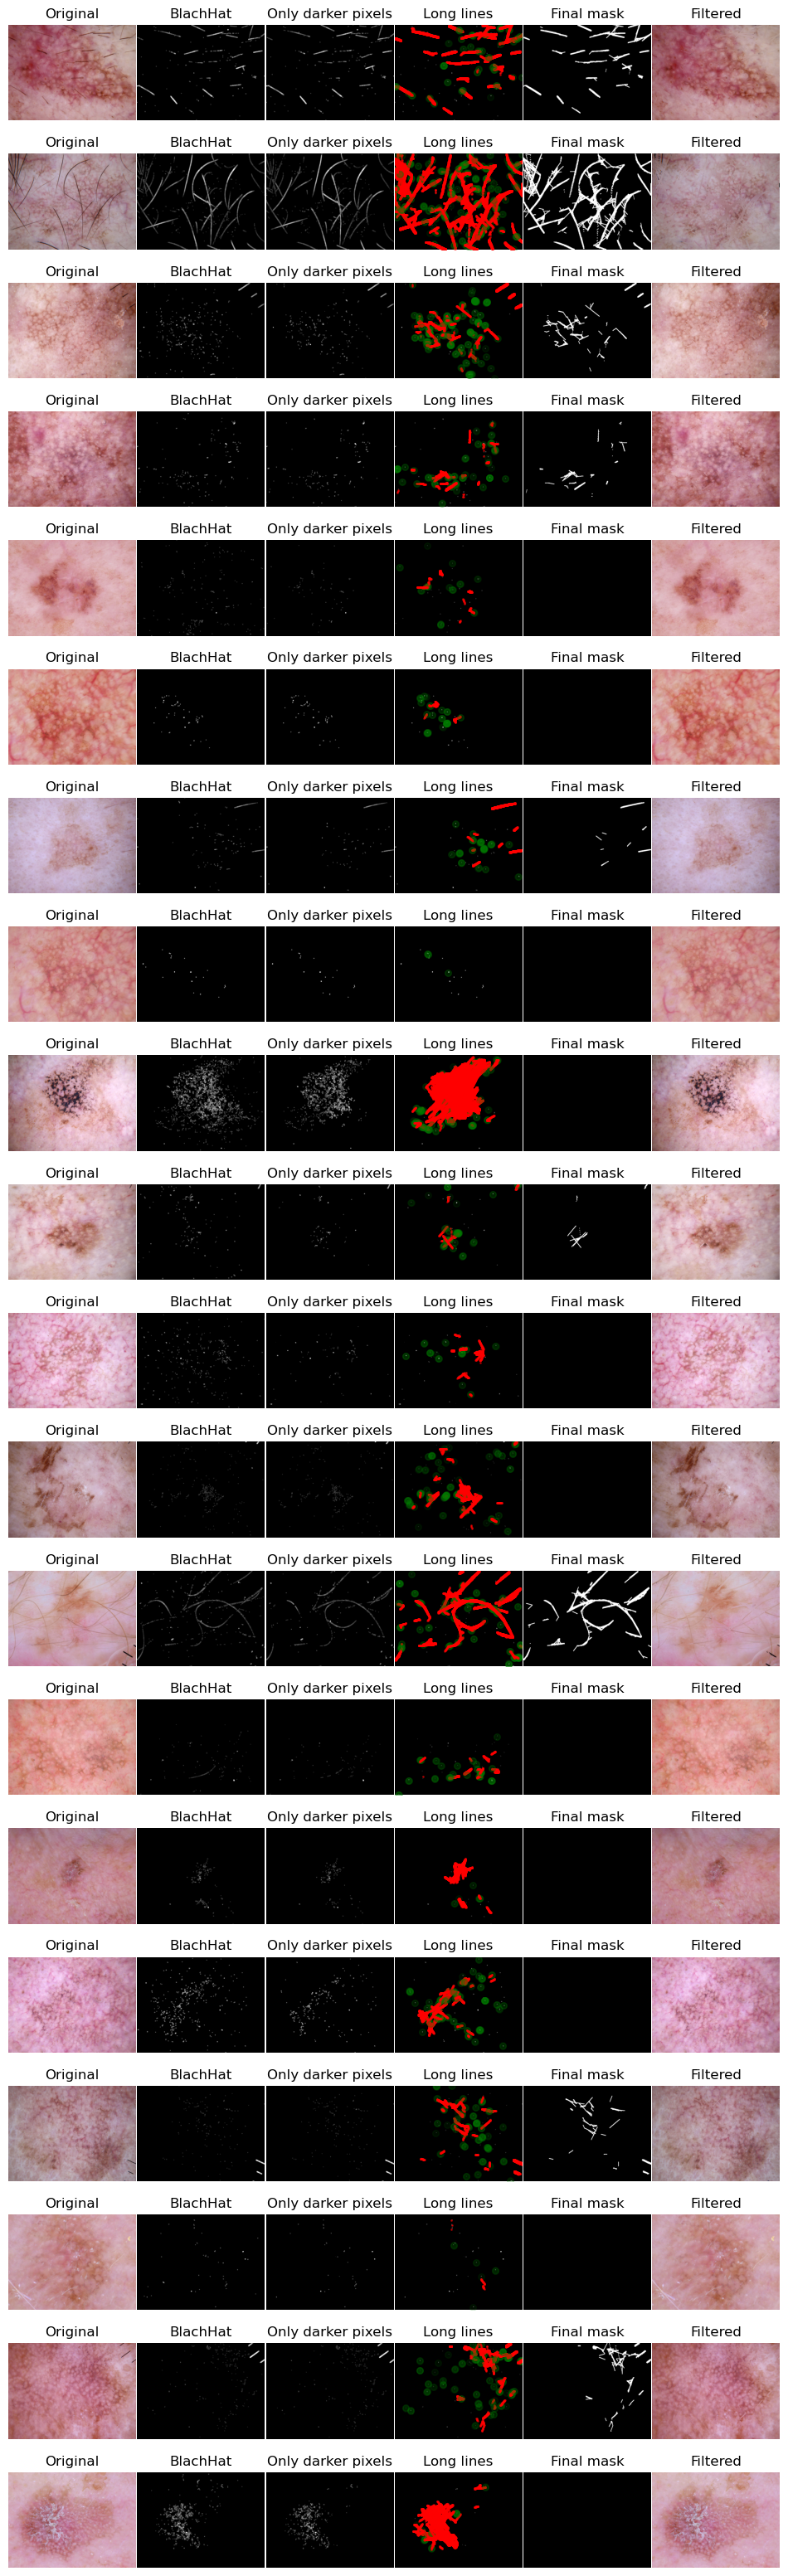

In [ ]:
images = []
for i in np.arange(0, 20, 1):
    img = np.array(train_data[i][0])
    images.append(img)

images_no_hair = remove_hair(images)